# 2nd Jupyter Notebook to Visualize TopoFlow Output

<b>Note:</b>  This notebook uses new visualization functions from <b>topoflow.utils.visualize.py</b>.  

Instructions for how to set up a <b>conda environment</b> for running this notebook can be found in <b>Appendix 1</b>.  <br>See the link in the Table of Contents.

### Table of Contents

1.  <a href="#intro">Introduction</a> <br>
2.  <a href="#make_dirs">Create some directories in your home directory</a> <br>
3.  <a href="#imports">Import Required Python Packages</a> <br>
4.  <a href="#read_grid">Read grid from a grid stack in a TF netCDF file</a> <br>
5.  <a href="#grid_image">Create a color image of the grid</a> <br>
6.  <a href="#stack_images">Create a set of image files from a TF grid stack</a> <br>
7.  <a href="#stack_movie">Make a movie from a set of grid image files</a> <br>
8.  <a href="#ts_plot">Create a time series plot</a> <br>
9.  <a href="#profile_plot">Create a plot of one profile in a profile series</a> <br>
10. <a href="#ps_images">Create a set of image files from a TF profile series</a> <br>
11. <a href="#ps_movie">Make a movie from profiles in a TF profile series</a> <br>
12. <a href="#setup">Appendix 1: &nbsp; Set up a conda environment for this notebook</a>

## Introduction  <a id="intro"></a>

TopoFlow stores values of output variables in multiple file formats, but the main one is netCDF format.  This Jupyter notebook shows how to read values of variables from TopoFlow netCDF output files and to then visualize them.

The TopoFlow model consists of a collection of <b>components</b>, each of which is able to model a particular hydrologic process in a particular way.  It provides a very flexible, <b>plug-and-play</b> modeling environment where a user specifies which set of components they want to use.  The EMELI framework then assembles these components into a functioning hydrologic model.

Each TopoFlow component has its own configuration file  or <b>cfg file</b> ending in the extension ".cfg".  These are text files that can be edited by hand or with scripts and they set the options, parameters, names of input files, etc. that are to be used by the component for a particular model run.  This particular model run is characterized by a <b>case prefix</b> (case as in scenario).  TopoFlow input files that describe static features of the site (a geographic bounding box) to be modeled start with a <b>site prefix</b> and do not change between model runs.  TopoFlow input and configuration files that correspond to a particular scenario (e.g. time period, climate forcing, parameter settings, choice of components, etc.) start with the case prefix.

In a model component's CFG file, there are toggles that determine which variables are to be written to files, and how often.  Since TopoFlow is a spatial hydrologic model, most variables are computed on a grid (2D array) that changes with each model time step.  Users can choose to write out this entire grid to a file at some time interval (save_grid_dt), and/or they can write out values for specific grid cells (0D) within the grid at some other time interval (save_pixels_dt).

The various types of TopoFlow output can be summarized as follows.  In each case, the output file contains values of some variable (say V) that <b>vary in time</b>, that is, a <b>series</b>.  Output filenames start with the <b>case prefix</b>.  The dimensionality of the output is indicated in the output file name with "0D_", "1D_", "2D_" or "3D_" followed by a variable name abbreviation (e.g. "Q" or "d-flood").

<b>0D = Time series</b> (or Point series) <br>
Scalar values of V, at one or more model grid cells. <br>
Formats:  (1) netCDF, and (2) multi-column text (i.e. CSV) <br>
Utility:  topoflow/utils/ncts_files.py <br>
Example:  river depth over time for given grid cell <br>
Note:     monitored grid cells are specified in [case_prefix]_outlets.txt. <br>

<b>1D = Profile series</b> <br>
A 1D array of values of V, at one or more grid cells . <br>
Formats: (1) netCDF<br>
Utility:  topoflow/utils/ncps_files.py<br>
Example:  1D, vertical slice of a 3D array (e.g. soil moisture profile) <br>
Note:     Chosen grid cells are specified in [case_prefix]_outlets.txt. <br>

<b>2D = Grid series (or stack)</b> <br>
A 2D array of values of V, for the entire model grid (all cells).<br>
Formats:  (1) netCDF, (2) RTS, (3) BOV <br>
Utility:  topoflow/utils/ncgs_files.py <br>
Example:  river discharges for the entire model grid <br>

<b>3D = "Cube" series</b> <br>
A 3D array of values of V, for entire model grid and various depths.<br>
Formats:  (1) netCDF <br>
Utility:  topoflow/utils/nccs_files.py <br>
Example:  3D array of subsurface soil moisture (grid + depth). <br>


# Create some directories in your home directory  <a id="make_dirs"></a>

In [1]:
import glob
import os, os.path
import shutil

home_dir = os.path.expanduser("~")
print('Home directory =', home_dir)

# Baro River, with mouth near Gambella, Ethiopia
BARO = False
if (BARO):
    site_prefix = 'Baro_Gam_1min'
    # case_prefix = 'Test1'
    case_prefix = 'Test2'
    test_dir    = home_dir + '/TF_Tests'

# Treynor River, in Iowa (part of Nishnabotna R.)
TREYNOR = True
if (TREYNOR):
    site_prefix = 'Treynor'
    case_prefix = 'June_20_67'
    # case_prefix = 'June_07_67'
    test_dir    = home_dir + '/TF_Output'
    
output_dir = test_dir + '/' + site_prefix
print('Output directory =', output_dir)

if not(os.path.exists( test_dir )):   os.mkdir( test_dir )
if not(os.path.exists( output_dir )): os.mkdir( output_dir)

# This is now done below as needed
# png_dir  = output_dir + '/' + 'png_files'
# png_dir2 = output_dir + '/' + 'png_files2'
# if not(os.path.exists( png_dir )):    os.mkdir( png_dir)
# if not(os.path.exists( png_dir2 )):   os.mkdir( png_dir2)
    
os.chdir( output_dir )

Home directory = /Users/peckhams
Output directory = /Users/peckhams/TF_Output/Treynor


# Import required Python packages <a id="imports"></a>

In [2]:
from topoflow.utils import visualize as tfvis


Importing TopoFlow 3.6 package modules:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 
Paths for this package:
framework_dir = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/framework/
parent_dir    = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/
examples_dir  = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/
__file__      = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/framework/emeli.py
__name__      = topoflow.framework.emeli
 


# Read grid from a grid stack in a TF netCDF file  <a id="read_grid"></a>

In [3]:
nc_file = case_prefix + '_2D-Q.nc'
# nc_file = case_prefix + '_2D-d-flood.nc'

(grid, long_name, extent) = tfvis.read_grid_from_nc_file(nc_file, time_index=3)


var_names in netCDF file =
['time', 'X', 'Y', 'Q']
long_name = volumetric_discharge
var_name  = Q
var_units = m^3/s
n_grids   = 100
extent = 
[277850.358, 278720.358, 4560090.42, 4561410.42]
grid shape = (44, 29)
min(grid)  = 0.0
max(grid)  = 8.159525e-05


# Create a color image of the grid  <a id="grid_image"></a>

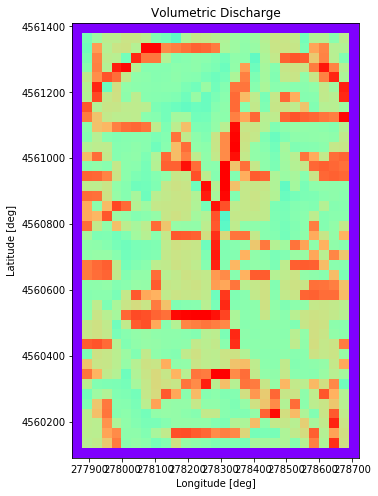

In [4]:
tfvis.show_grid_as_image( grid, long_name, extent=extent,
                          cmap='rainbow', stretch='power_stretch3',
                          xsize=8, ysize=8, dpi=None)


# Create a set of image files from a TF grid stack  <a id="stack_images"></a>

In [5]:
png_dir3 = output_dir + '/' + 'png_files3'
if not(os.path.exists( png_dir3 )): os.mkdir( png_dir3)

nc_file = case_prefix + '_2D-Q.nc'
# nc_file = case_prefix + '_2D-d-flood.nc'

tfvis.save_grid_stack_as_images( nc_file, png_dir3, extent=extent,
                                 xsize=8, ysize=8, dpi=192, REPORT=True)


Creating images from grid stack in nc_file:
  June_20_67_2D-Q.nc
  var name  = Q
  long name = volumetric_discharge
  n_grids   = 100
This may take a few minutes.
Working...
Finished saving 100 images to PNG files.


# Make a movie from a set of grid image files  <a id="stack_movie"></a>

In [6]:
fps = 10  # frames per second
mp4_file = case_prefix + '_Q_Grid_Movie.mp4'
tfvis.create_movie_from_images( mp4_file, png_dir3, fps=fps, REPORT=True)


Creating movie from 100 PNG files.
Working...
Finished creating movie, MP4 format.
  June_20_67_Q_Grid_Movie.mp4



# Create a time series plot  <a id="ts_plot"></a>

var_names in netCDF file =
['time', 'Q_34_16', 'Q_32_16', 'Q_37_19', 'Q_26_14', 'Q_30_15', 'Q_0_0']
var longitudes =
[277850.49133333337, 277850.49133333337, 277850.51633333333, 277850.47466666665, 277850.483, 277850.358]
var latitudes =
[4560090.703333333, 4560090.6866666665, 4560090.7283333335, 4560090.636666667, 4560090.67, 4560090.42]



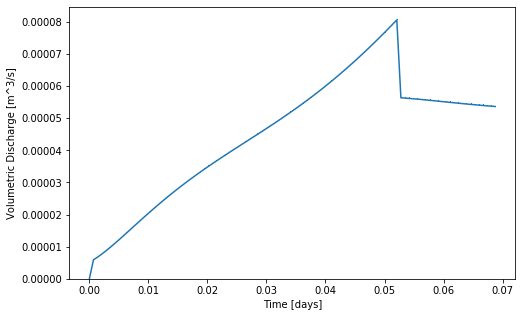

In [7]:
nc_file = case_prefix + '_0D-Q.nc'
# nc_file = case_prefix + '_0D-d-flood.nc'

tfvis.plot_time_series(nc_file, output_dir=output_dir, marker=',',
                       REPORT=True, xsize=8, ysize=5)


# Create a plot of one profile in a profile series  <a id="profile_plot"></a>

var_names in netCDF file =
['time', 'z', 'q_34_16', 'q_32_16', 'q_37_19', 'q_26_14', 'q_30_15', 'q_0_0']
var longitudes =
[277850.49133333337, 277850.49133333337, 277850.51633333333, 277850.47466666665, 277850.483, 277850.358]
var latitudes =
[4560090.703333333, 4560090.6866666665, 4560090.7283333335, 4560090.636666667, 4560090.67, 4560090.42]



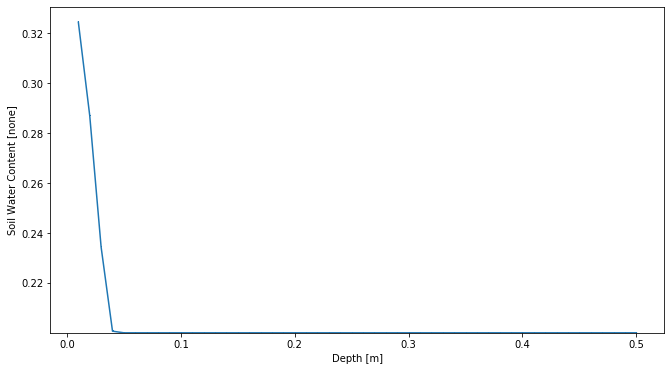

In [8]:
nc_file = case_prefix + '_1D-q.nc'
# nc_file = case_prefix + '_1D-p.nc'
# nc_file = case_prefix + '_1D-K.nc'
# nc_file = case_prefix + '_1D-v.nc'

tfvis.plot_z_profile(nc_file, time_index=10,
                     output_dir=output_dir, marker=',',
                     REPORT=True, xsize=8, ysize=5)


# Create a set of image files from a TF profile series  <a id="ps_images"></a>

In [18]:
png_dir4 = output_dir + '/' + 'png_files4'
if not(os.path.exists( png_dir4 )): os.mkdir( png_dir4)

nc_file = case_prefix + '_1D-q.nc'
ymin = 0.0
ymax = 0.5
# nc_file = case_prefix + '_1D-p.nc'
# nc_file = case_prefix + '_1D-K.nc'
# nc_file = case_prefix + '_1D-v.nc'
# ymin = None
# ymax = None

# Set ymin and ymax to make them same for all plots.
tfvis.save_profile_series_as_images(nc_file, png_dir=png_dir4,
                   ymin=ymin, ymax=ymax,    # (same for all plots)
                   # ymin=None, ymax=None,  # (auto for each plot)
                   marker=',', REPORT=True,
                   xsize=8, ysize=5, dpi=192)


Creating images from z profiles in nc_file:
  June_20_67_1D-q.nc
  var name  = q_34_16
  long_name = soil_water_content
  Number of profiles = 200
This may take a few minutes.
Working...
Finished saving 200 images to PNG files.


# Make a movie from profiles in a TF profile series  <a id="ps_movie"></a>

In [19]:
fps = 20  # frames per second
mp4_file = case_prefix + '_Profile_Movie_q.mp4'
# mp4_file = case_prefix + '_Profile_Movie_p.mp4'
# mp4_file = case_prefix + '_Profile_Movie_K.mp4'
# mp4_file = case_prefix + '_Profile_Movie_v.mp4'

tfvis.create_movie_from_images( mp4_file, png_dir4, fps=fps, REPORT=True)


Creating movie from 200 PNG files.
Working...
Finished creating movie, MP4 format.
  June_20_67_Profile_Movie_q.mp4



In [11]:
# from IPython.display import Video

#--------------------------------------------------------------------
# Note: For some reason, the mp4 file must be in the same directory
#       as the .ipynb file (e.g. /User/peckhams/Jupyter).
#       Specifying the full path by these methods doesn't work.
#       Creating a symbolic link should work, however.
#--------------------------------------------------------------------
# mp4_file2 = output_dir + '/' + mp4_file
## mp4_file2 = '../../..' + output_dir + '/' + mp4_file
## print( mp4_file2 )
# os.path.expandvars( mp4_file2 )
# Video( mp4_file2, width=600, height=450)

# help(Video)

#----------------------------------------------
# Movie is (8" x 6"), so aspect ratio is 3/4.
# 450/600 = 3/4.  Only works if the MP4 file
# is in the same directory as the notebook.
#----------------------------------------------
# Video( mp4_file, width=600, height=450)


# Appendix 1: &nbsp; Set up a conda environment for this notebook  <a id="setup"></a>

Before you can run the code in this notebook, you will need to install the TopoFlow 3.6 Python package.

It is recommended to use Python 3.7 (or higher) from an Anaconda distribution and to install TopoFlow 3.6 in a conda environment called "tfvis".  In Anaconda is already installed, you can use the following commands on Mac or Linux to install TopoFlow.  This helps to isolate it from the rest of your Python environment to avoid potential package conflicts.

```bash
% conda update -n base conda
% conda create --name tfvis
% conda activate tfvis
% conda install matplotlib
% conda install imageio
% pip install imageio-ffmpeg  (an imageio extension)

Download the TopoFlow 3.6 package from GitHub repo "topoflow36".
Copy it somewhere. Denote this full path as TF36_DIR.
e.g. TF36_DIR = /Users/peckhams/Dropbox/TopoFlow_3.6

% cd TF36_DIR
% pip install -e .   (-e is the editable/developer option)
% cd

If you would like to run the notebook in jupyterlab, also do this.
% conda install -c conda-forge jupyterlab
% conda install -c conda-forge nb_conda_kernels (needed for conda envs)
% jupyter lab
```

Finally, choose <b>TopoFlow_Getting_Started.ipynb</b> in Jupyter Notebook or Jupyter Lab.
In Jupyter Lab, choose the kernel:  Python [conda evn:tfvis].  Whenever you want to run this notebook, you will then need to switch to this "tfvis" environment with the command: "conda activate tfvis".

# Appendix 2:   &nbsp; Show a video in a markdown cell

<video controls src=mp4_file2 />

In [12]:
# An alternate approach.
#-------------------------
# from IPython.display import HTML

# HTML("""
# <video width="320" height="240" controls>
#   <source src=mp4_file type="video/mp4">
# </video>
# """)